# Full-Learning MNIST PC Network
Purpose: To see if we can learn not only (v)<->(e) connections, but also the (e)<->(v) connections. Those connections have previously been set to 1:1 identity mappings. But here they start as random connection weights, and learn using the same update rule as the other learning connections.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import  datasets, transforms
from IPython.display import display
from ipywidgets import FloatProgress

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

np.set_printoptions(precision=4)

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:4") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

# Dataset

In [2]:
ds = datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [69]:
class SmallMNIST(Dataset):
    def __init__(self, ds_full, n=100, type='identity'):
        self.samples = []
        self.n_classes = 10
        self.input_dim = 784
        for i in range(n):
            x = ds_full[i][0].flatten()
            if type=='inv_logistic':
                x = x*0.94 + 0.03
                x = torch.log( x / (1.0-x) )
                x[x>5.] = 5.
                x[x<-5] = -5.
            classvec = torch.zeros(10, dtype=torch.float32, device=device)
            classvec[ds_full[i][1]] = 1.
            sample = (x.clone().detach().float().to(device), classvec)
            #sample = [A[r]+noise*torch.randn_like(A[r]), B[r]+noise*torch.randn_like(B[r])]
            self.samples.append(sample)
    
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)

    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)

    def Show(self, idx):
        plt.imshow(np.reshape(self.samples[idx][0].cpu(), (28,28)));

In [31]:
myds = SmallMNIST(ds, n=10000)

In [70]:
myds2 = SmallMNIST(ds, n=100, type='inv_logistic')

In [57]:
myds[5][1]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:4')

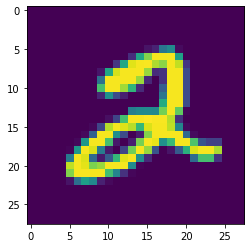

In [33]:
myds.Show(5)

# Create Network

In [34]:
#ds = SimpleDataset(A, B, n=50, noise=0.2)
dl = DataLoader(myds, batch_size=250, shuffle=True)

In [41]:
input_dim = 784
mid_dim = 100
net = PCNetwork.PCNetwork(device=device)
net.AddLayer(PCLayer.PCLayer(n=myds.input_dim, device=device))  # [0] v0 input

net.AddLayer(PCLayer.PCLayer(n=mid_dim, device=device))       # [1] e1 error
net.AddLayer(PCLayer.PCLayer(n=mid_dim, device=device))       # [2] v1 class

net.AddLayer(PCLayer.PCLayer(n=myds.n_classes, device=device))  # [3] e2 error
net.AddLayer(PCLayer.PCLayer(n=myds.n_classes, device=device))  # [4] v2 class

af0 = 'identity'
af = 'tanh'
sym = True
net.Connect(v_idx=0, e_idx=1, type='general', sym=sym, act_text=af0)
net.Connect(e_idx=1, v_idx=2, type='general', sym=True, act_text=af)
net.Connect(v_idx=2, e_idx=3, type='general', sym=sym, act_text=af)
net.Connect(e_idx=3, v_idx=4, type='general', sym=True, act_text=af)

net.SetTau(0.02)

# Training

In [ ]:
net.ClearHistory()
net.Probe(False)
net.Learning(True)
net.SetGamma(0.1)
mult = 0.1
l = 0.
h = 1.

net.con[0].SetRandom(random=1./np.sqrt(input_dim)) # e1-v1
net.con[1].SetIdentity()
net.con[2].SetRandom(random=1./np.sqrt(mid_dim)) # v1-e2
net.con[3].SetIdentity()

net.SetDynamicWeightDecay(0.0, 0.8)
net.SetRepelSmallWeights(0.0)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [59]:
net.ClearHistory()
net.Probe(False)
net.Learning(True)
net.SetGamma(0.05)
l = 0.
h = 1./10.

net.con[0].SetRandom(random=1.*2/np.sqrt(input_dim)) # e1-v1
#net.con[0].SetRandomUniform(low=l, high=h) # e1-v1
net.con[1].SetRandomUniform(low=l, high=1./mid_dim) # e1-v1
net.con[2].SetRandom(random=1./np.sqrt(mid_dim)) # v1-e2
#net.con[2].SetRandomUniform(low=l, high=h) # v1-e2
net.con[3].SetRandomUniform(low=l, high=h) # e2-v2

net.SetDynamicWeightDecay(0.0, 0.8)
net.SetRepelSmallWeights(0.0)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [ ]:
net.Save('mnist4.net')

In [61]:
net = PCNetwork.PCNetwork.Load('mnist4.net')
#net = PCNetwork.PCNetwork.Load('mnist4_57percent.net')

In [37]:
net.ClearHistory()

In [60]:
for c in net.con:
    print(c.WeightNorms())

(tensor(20.0000, device='cuda:4'), tensor(20.0000, device='cuda:4'))
(tensor(0.5713, device='cuda:4'), tensor(0.5713, device='cuda:4'))
(tensor(3.0971, device='cuda:4'), tensor(3.0971, device='cuda:4'))
(tensor(0.5966, device='cuda:4'), tensor(0.5966, device='cuda:4'))


In [43]:
# Shorter run time, one epoch, 10000 samples
net.Learning(True)
net.con[0].Learning(False)
net.con[1].Learning(True)
net.con[2].Learning(False)
net.con[3].Learning(True)
net.SetDynamicWeightDecay(0.0, 0.8)
net.Learn(dl, T=1., epochs=1)
net.Save('mnist4.net')

Epoch: 0 weight decay = 0.0


In [ ]:
net.Learning(True)
net.con[0].Learning(True)
net.con[1].Learning(False)
net.con[2].Learning(True)
net.con[3].Learning(False)
net.SetDynamicWeightDecay(0.0, 0.8)
net.Learn(dl, T=1., epochs=1)
net.Save('mnist4.net')

Epoch: 0 weight decay = 0.0


In [68]:
for c in net.con:
    print(c.WeightNorms())

(tensor(13.0891, device='cuda:4'), tensor(13.0891, device='cuda:4'))
(tensor(20.7215, device='cuda:4'), tensor(20.7215, device='cuda:4'))
(tensor(0.6788, device='cuda:4'), tensor(0.6788, device='cuda:4'))
(tensor(0.9784, device='cuda:4'), tensor(0.9784, device='cuda:4'))


In [64]:
# T=3, 10000 samples
net.Learning(True)
net.con[0].Learning(False)
net.con[1].Learning(True)
net.con[2].Learning(False)
net.con[3].Learning(True)
net.SetDynamicWeightDecay(0.0, 0.8)
net.Learn(dl, T=1., epochs=2)
net.Save('mnist4.net')

Epoch: 0 weight decay = 0.0
Epoch: 1 weight decay = 0.0


In [65]:
net.Learning(True)
net.con[0].Learning(True)
net.con[1].Learning(False)
net.con[2].Learning(True)
net.con[3].Learning(False)
net.SetDynamicWeightDecay(0.0, 0.8)
net.Learn(dl, T=1., epochs=2)
net.Save('mnist4.net')

Epoch: 0 weight decay = 0.0
Epoch: 1 weight decay = 0.0


In [62]:
tinyds = SmallMNIST(ds, n=10)
tinydl = DataLoader(tinyds, batch_size=10, shuffle=False)
net.Reset()
net.Probe(True)
net.Learning(True)
net.Learn(tinydl, T=5., epochs=1)
net.Plot(idx=[0]);

Epoch: 0 weight decay = 0.0


In [58]:
net.Reset()
#net.Save('mnist4_57percent.net')

# Classification

In [66]:
net.Reset()
net.Probe(False)
net.SetActivityDecay( 0.0 )
y = net.Predict(myds.Inputs()[:100], T=4.)
print(y[:10])
print(myds.Targets()[:10])

tensor([[ 0.1194,  0.1170,  0.0750,  0.0903,  0.0296,  0.0989,  0.0536,  0.0786,
          0.0848,  0.0471],
        [ 0.1935,  0.0568,  0.0799,  0.1017, -0.0059,  0.0979, -0.0101,  0.0818,
          0.0674,  0.0307],
        [ 0.1422,  0.1106,  0.0723,  0.0953,  0.0150,  0.1051,  0.0131,  0.1009,
          0.0653,  0.0492],
        [ 0.0181,  0.1724,  0.0494,  0.0699,  0.1054,  0.1005,  0.0633,  0.1251,
          0.0670,  0.1021],
        [ 0.0048,  0.0778,  0.0405,  0.0234,  0.1407,  0.0583,  0.1324,  0.0959,
          0.0191,  0.1020],
        [-0.0247,  0.0844,  0.0357,  0.0140,  0.1663,  0.0545,  0.1414,  0.0996,
          0.0182,  0.1151],
        [-0.0226,  0.1640,  0.0473,  0.0492,  0.1338,  0.0849,  0.1298,  0.1032,
          0.0679,  0.1064],
        [ 0.2648,  0.0620,  0.1034,  0.1394, -0.0758,  0.1168, -0.0413,  0.0612,
          0.1061, -0.0086],
        [ 0.0137,  0.1715,  0.0454,  0.0674,  0.1069,  0.0990,  0.0484,  0.1290,
          0.0619,  0.1041],
        [ 0.0021,  

In [67]:
# Check the accuracy
correct = 0
for ym,tm in zip(torch.argmax(y, axis=1), torch.argmax(myds.Targets()[:100], axis=1)):
    if ym.item()==tm.item():
        correct += 1
print(str(correct)+' correct out of 100')

35 correct out of 100


In [ ]:
ds.Plot(labels=y, idx=(4,8))

# Generation

In [ ]:
net.Reset(random=1.)
net.SetActivityDecay(0.02)
X = net.Generate(ds.Targets(), T=15.)

In [ ]:
sidx = (0,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

In [ ]:
sidx = (4,8)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);